In [281]:
%load_ext autoreload
%autoreload 2

# To load the environment variable defined in the .env file
from dotenv import load_dotenv
load_dotenv();

import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from scipy import ndimage
from scipy import stats
from sklearn.neighbors import KernelDensity
import seaborn as sns

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [245]:
season_year = 2017
season_type = "Regular"

In [246]:
import src.data.NHLDataManager as DataManager
data_manager = DataManager.NHLDataManager()
data = data_manager.load_data(season_year=season_year, season_type=season_type)

  0%|          | 0/1271 [00:00<?, ?it/s]

In [247]:
game_numbers = data_manager.get_game_numbers(season_year=season_year, season_type=season_type)
data_season_df = data_manager.get_goals_and_shots_df(season_year=season_year, season_type=season_type, game_number=game_numbers[0])

for game_number in game_numbers[1:]:
    data_season_df = pd.concat([data_season_df, data_manager.get_goals_and_shots_df(season_year=season_year, season_type=season_type, game_number=game_number)])


In [137]:
data_season_df

,Game ID,Event Index,Time,Period,Team,Type,Shot Type,Shooter,Goalie,Empty Net,Strength,X,Y
0,2019020001,4,00:25,1,Ottawa Senators (OTT),GOAL,Tip-In,Brady Tkachuk,Frederik Andersen,False,Even,85.0,-1.0
1,2019020001,145,02:20,2,Toronto Maple Leafs (TOR),GOAL,Wrist Shot,Frederik Gauthier,Craig Anderson,False,Even,86.0,0.0
2,2019020001,165,04:42,2,Toronto Maple Leafs (TOR),GOAL,Slap Shot,Trevor Moore,Craig Anderson,False,Even,84.0,2.0
3,2019020001,172,05:51,2,Ottawa Senators (OTT),GOAL,Wrist Shot,Scott Sabourin,Frederik Andersen,False,Even,-83.0,-6.0
4,2019020001,181,08:02,2,Toronto Maple Leafs (TOR),GOAL,Wrist Shot,Auston Matthews,Craig Anderson,False,Even,83.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,2019021082,288,16:45,3,Ottawa Senators (OTT),SHOT,Wrist Shot,Nick Paul,Calvin Petersen,NaN,NaN,77.0,-23.0
61,2019021082,290,17:20,3,Los Angeles Kings (LAK),SHOT,Wrist Shot,Drew Doughty,Craig Anderson,NaN,NaN,-76.0,38.0
62,2019021082,291,17:22,3,Los Angeles Kings (LAK),SHOT,Wrist Shot,Gabriel Vilardi,Craig Anderson,NaN,NaN,-79.0,10.0
63,2019021082,298,18:50,3,Ottawa Senators (OTT),SHOT,Wrist Shot,Thomas Chabot,Calvin Petersen,NaN,NaN,81.0,-7.0


In [248]:
total_shots_league = len(data_season_df)
number_of_games = len(data_season_df['Game ID'].unique())
print(f'Total number of shots during season {season_year} ({season_type}) = {total_shots_league}')
print(f'Number of games during season {season_year} ({season_type}) = {number_of_games}')

mean_shots_per_hour = total_shots_league / number_of_games
print(f'Mean shots per hour during season {season_year} ({season_type}) = {mean_shots_per_hour}')

total_goals_league = len(data_season_df[data_season_df['Type'] == 'GOAL'])
mean_goals_per_hour = total_goals_league / number_of_games
print(f'Mean goals per hour during season {season_year} ({season_type}) = {mean_goals_per_hour}')


Total number of shots during season 2017 (Regular) = 81873
Number of games during season 2017 (Regular) = 1271
Mean shots per hour during season 2017 (Regular) = 64.4162077104642
Mean goals per hour during season 2017 (Regular) = 6.051140833988985


In [249]:
list_of_teams = data_season_df['Team'].unique()
number_of_teams = len(list_of_teams)

print(f'Number of Teams during season {season_year} ({season_type}) = {number_of_teams}')

Number of Teams during season 2017 (Regular) = 31


In [250]:
data_season_df[['Team', 'Type', 'X', 'Y', 'Period', 'Game ID']].head(15)
print(data_season_df.columns)

Index(['Game ID', 'Event Index', 'Time', 'Period', 'Team', 'Type', 'Shot Type',
       'Shooter', 'Goalie', 'Empty Net', 'Strength', 'X', 'Y'],
      dtype='object')


In [251]:
df_total_shots_per_team = data_season_df[['Team', 'Type', 'X', 'Y']].dropna().groupby('Team').size()
df_mean_shots_per_team_per_hour = df_total_shots_per_team / 82.
print(df_total_shots_per_team.sample(10))

Team
Colorado Avalanche (COL)     2439
Anaheim Ducks (ANA)          2514
Edmonton Oilers (EDM)        2756
Vancouver Canucks (VAN)      2486
Calgary Flames (CGY)         2777
Tampa Bay Lightning (TBL)    2696
Minnesota Wild (MIN)         2501
Dallas Stars (DAL)           2579
Florida Panthers (FLA)       2840
New York Rangers (NYR)       2562
dtype: int64


In [286]:
from tkinter import Y


x_shots_season = data_season_df['X'].to_numpy().copy()
y_shots_season = data_season_df['Y'].to_numpy().copy()

# Pour compenser le changement de côté ?
# Est-ce qu'on considère qu'une coordonnée négative est nécessairement dû à un chagement de côté ?
# Pour le moment, faisons cette supposition
x_shots_season = abs(x_shots_season)

print(min(x_shots_season), max(x_shots_season))
print(min(y_shots_season), max(y_shots_season))


0.0 99.0
-42.0 42.0


(14, 14)
(14, 14)
(225, 2)


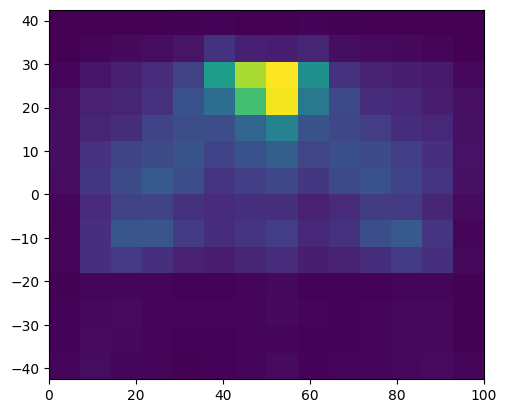

In [324]:
x_min, x_max = 0., 100.
y_min, y_max = -42.5, 42.5

num_pts = 15
x_grid = np.linspace(x_min, x_max, num_pts)
y_grid = np.linspace(y_min, y_max, num_pts)

ret  = stats.binned_statistic_2d(x_shots_season.tolist(), y_shots_season.tolist(), None, 'count', bins=[x_grid.tolist(), y_grid.tolist()])
grid_XY_shots_per_season = ret.statistic
grid_XY_shots_per_hour = grid_XY_shots_per_season / number_of_games
seaborn.kdeplot


print(grid_XY_shots_per_season.shape)

kde = KernelDensity(bandwidth=0.04, kernel="gaussian")
kde.fit(grid_XY_shots_per_hour)

print(grid_XY_shots_per_hour.shape)
X, Y = np.meshgrid(x_grid, y_grid, sparse=False) 
xy = np.vstack([X.ravel(), Y.ravel()]).T
print(xy.shape)
# Z = np.exp(kde.score_samples(xy))
# Z = Z.reshape(X.shape)
# print(Z.shape)


# H, y_grid, x_grid = np.histogram2d(x_coords, y_coords, bins=(x_grid, y_grid))
# # H = H.T

# grid_XY_shots_per_season = H.astype(int)
# grid_XY_shots_per_hour = grid_XY_shots_per_season / number_of_games
plt.imshow(grid_XY_shots_per_hour, interpolation='nearest', origin='lower', extent=[x_grid[0], x_grid[-1], y_grid[0], y_grid[-1]])

# (y_ind, x_ind) = np.where(grid_XY_shots_per_season == grid_XY_shots_per_season.max())
# print(x_grid[x_ind], y_grid[y_ind])

# print(grid_XY_shots_per_hour.max())

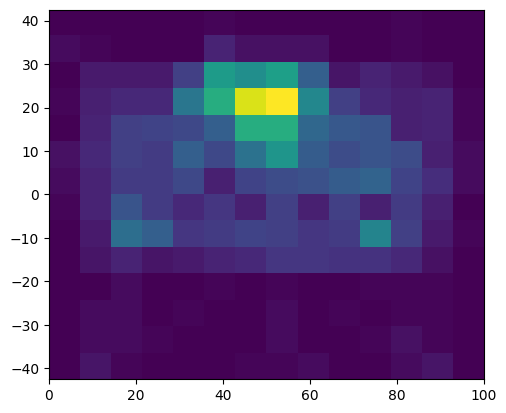

In [296]:
data_season_subset_df = data_season_df[['Team', 'Type', 'X', 'Y', 'Period', 'Game ID']]
data_season_tampay_df = data_season_subset_df[data_season_subset_df['Team'] == "Tampa Bay Lightning (TBL)"]

data_season_tampay_df.head(10)

x_shots_tampay = data_season_tampay_df['X'].to_numpy().copy()
y_shots_tampay = data_season_tampay_df['Y'].to_numpy().copy()

ret = stats.binned_statistic_2d(x_shots_tampay.tolist(), y_shots_tampay.tolist(), None, 'count', bins=[x_grid.tolist(), y_grid.tolist()])
grid_XY_tampay_shots = ret.statistic
grid_XY_tampay_shots_per_hour = grid_XY_tampay_shots / number_of_games

grid_XY_tampay_shots_per_hour

plt.imshow(grid_XY_tampay_shots_per_hour, interpolation='nearest', origin='lower', extent=[x_grid[0], x_grid[-1], y_grid[0], y_grid[-1]])


In [276]:
kde = KernelDensity(bandwidth=0.04, kernel="gaussian", algorithm="ball_tree")
kde.fit(diff_XY)

KernelDensity(algorithm='ball_tree', bandwidth=0.04)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


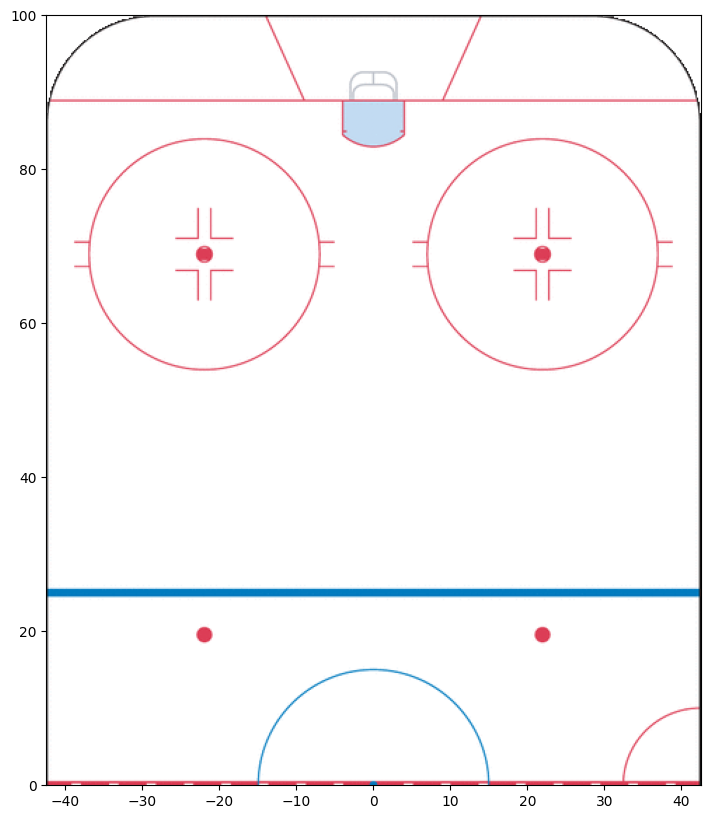

In [256]:
plt.figure(figsize = (10,10))
img = mpimg.imread("./figures/nhl_rink.png")
(h, w, c) = img.shape
img_half = img[:, int(w/2):, :]

rink_img = ndimage.rotate(img_half, 90)

# The goal is located 11 inches from the end of the rink
# The middle line is (100-11) 89 inches from the goal
# plt.imshow(rink_img, extent=[-42.5, 42.5, 89, -11])
plt.imshow(rink_img, extent=[-42.5, 42.5, 0, 100])